# Fine Tuning DistilBERT for Multiclass Text Classification

## Model - 'distilbert-base-uncased'




## First What is BERT?

BERT stands for Bidirectional Encoder Representations from Transformers. The name itself gives us several clues to what BERT is all about.

BERT architecture consists of several Transformer encoders stacked together. Each Transformer encoder encapsulates two sub-layers: a self-attention layer and a feed-forward layer.

### There are two different BERT models:

- BERT base, which is a BERT model consists of 12 layers of Transformer encoder, 12 attention heads, 768 hidden size, and 110M parameters.

- BERT large, which is a BERT model consists of 24 layers of Transformer encoder,16 attention heads, 1024 hidden size, and 340 parameters.



BERT Input and Output
BERT model expects a sequence of tokens (words) as an input. In each sequence of tokens, there are two special tokens that BERT would expect as an input:

- [CLS]: This is the first token of every sequence, which stands for classification token.
- [SEP]: This is the token that makes BERT know which token belongs to which sequence. This special token is mainly important for a next sentence prediction task or question-answering task. If we only have one sequence, then this token will be appended to the end of the sequence.


It is also important to note that the maximum size of tokens that can be fed into BERT model is 512. If the tokens in a sequence are less than 512, we can use padding to fill the unused token slots with [PAD] token. If the tokens in a sequence are longer than 512, then we need to do a truncation.

And that’s all that BERT expects as input.

BERT model then will output an embedding vector of size 768 in each of the tokens. We can use these vectors as an input for different kinds of NLP applications, whether it is text classification, next sentence prediction, Named-Entity-Recognition (NER), or question-answering.


------------

**For a text classification task**, we focus our attention on the embedding vector output from the special [CLS] token. This means that we’re going to use the embedding vector of size 768 from [CLS] token as an input for our classifier, which then will output a vector of size the number of classes in our classification task.

-----------------------

![Imgur](https://imgur.com/NpeB9vb.png)

-------------------------

In [ ]:
!pip  install transformers

In [ ]:
import transformers

In [ ]:
print(t)

In [ ]:
print(transformers.__version__)

4.38.2


In [ ]:
from transformers import DistilBertTokenizer
from transformers import TextClassificationPipeline

import tensorflow as tf
import pandas as pd
import json
import gc

from sklearn.model_selection import train_test_split

import re
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stopw = stopwords.words('english')

import seaborn as sns
import matplotlib.pyplot as plt
from plotly.offline import iplot

from tqdm import tqdm

/usr/local/lib/python3.10/dist-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/usr/local/lib/python3.10/dist-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/usr/local/lib/python3.10/dist-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
root_path = '/content/drive/MyDrive/updated_email (4).csv'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df = pd.read_csv(root_path)
df.head()

,text,spam,urgency
0,Subject: naturally irresistible your corporate...,1,Neutral
1,Subject: the stock trading gunslinger fanny i...,1,Neutral
2,Subject: unbelievable new homes made easy im ...,1,Neutral
3,Subject: 4 color printing special request add...,1,Neutral
4,"Subject: do not have money , get software cds ...",1,Urgent


In [ ]:
df.shape

(5728, 3)

# Histogram of the count of text

In [ ]:
df['count'] = df['text'].apply(lambda x: len(x.split()))

In [ ]:
df.head()

,text,spam,urgency,count
0,Subject: naturally irresistible your corporate...,1,Neutral,324
1,Subject: the stock trading gunslinger fanny i...,1,Neutral,89
2,Subject: unbelievable new homes made easy im ...,1,Neutral,87
3,Subject: 4 color printing special request add...,1,Neutral,98
4,"Subject: do not have money , get software cds ...",1,Urgent,52


<Figure size 800x800 with 0 Axes>

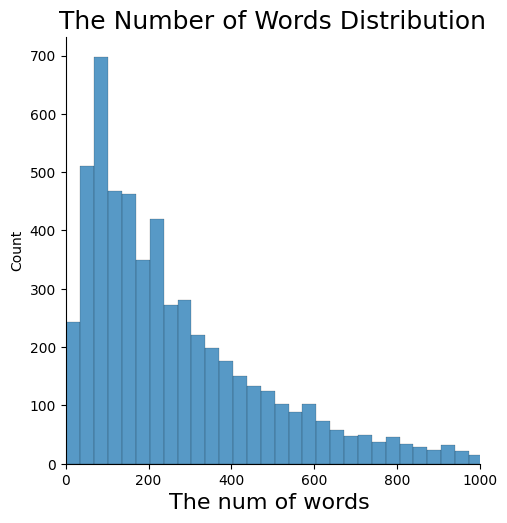

In [ ]:
plt.figure(figsize= (8, 8))

sns.displot(df['count'])

plt.xlim(0, 1000)

plt.xlabel('The num of words ', fontsize = 16)
plt.title("The Number of Words Distribution", fontsize = 18)
plt.show()



# Bar plot for each of the new category

In [ ]:
category_count = df['urgency'].value_counts()

categories = category_count.index

categories

Index(['Neutral', 'Urgent', ' Very Urgent', 'Non-urgent'], dtype='object', name='urgency')

In [ ]:
category_count

urgency
Neutral         4313
Urgent          1295
 Very Urgent      81
Non-urgent        39
Name: count, dtype: int64

In [ ]:
category_count.index

Index(['Neutral', 'Urgent', ' Very Urgent', 'Non-urgent'], dtype='object', name='urgency')

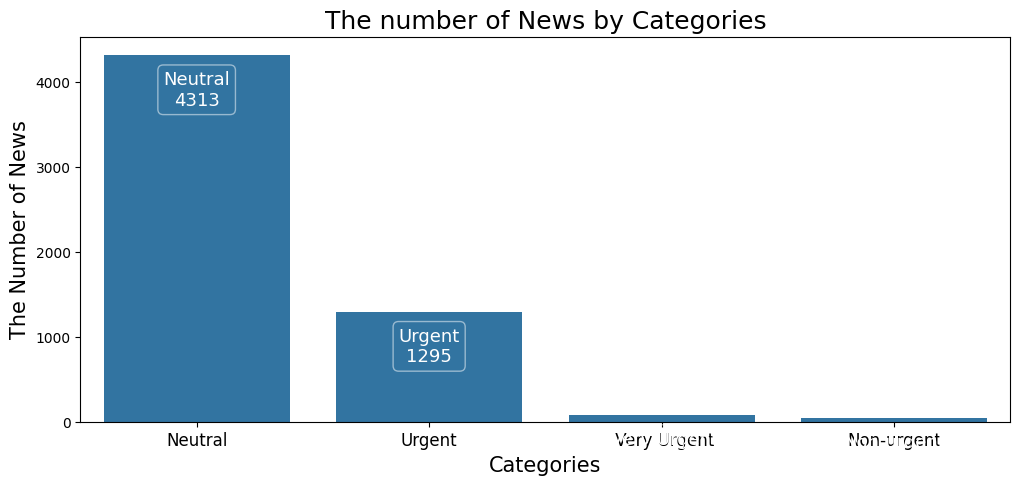

In [ ]:
fig = plt.figure(figsize= (12, 5))

ax = fig.add_subplot(111)

sns.barplot(x = category_count.index, y = category_count )

for a, p in enumerate(ax.patches):
    ax.annotate(f'{categories[a]}\n' + format(p.get_height(), '.0f'), xy = (p.get_x() + p.get_width() / 2.0, p.get_height()), xytext = (0,-25), size = 13, color = 'white' , ha = 'center', va = 'center', textcoords = 'offset points', bbox = dict(boxstyle = 'round', facecolor='none',edgecolor='white', alpha = 0.5) )

plt.xlabel('Categories', size = 15)

plt.ylabel('The Number of News', size= 15)

plt.xticks(size = 12)

plt.title("The number of emails by Categories" , size = 18)

plt.show()

In [ ]:
df['urgency'].unique()

array(['Neutral', 'Urgent', ' Very Urgent', 'Non-urgent'], dtype=object)

In [ ]:
df['encoded_text'] = df['urgency'].astype('category').cat.codes

df.head(10)

,text,spam,urgency,count,encoded_text
0,Subject: naturally irresistible your corporate...,1,Neutral,324,1
1,Subject: the stock trading gunslinger fanny i...,1,Neutral,89,1
2,Subject: unbelievable new homes made easy im ...,1,Neutral,87,1
3,Subject: 4 color printing special request add...,1,Neutral,98,1
4,"Subject: do not have money , get software cds ...",1,Urgent,52,3
5,"Subject: great nnews hello , welcome to medzo...",1,Neutral,84,1
6,Subject: here ' s a hot play in motion homela...,1,Neutral,1703,1
7,Subject: save your money buy getting this thin...,1,Neutral,95,1
8,Subject: undeliverable : home based business f...,1,Neutral,121,1
9,Subject: save your money buy getting this thin...,1,Neutral,95,1


In [ ]:
from matplotlib import pyplot as plt
_df_2['encoded_text'].plot(kind='hist', bins=20, title='encoded_text')
plt.gca().spines[['top', 'right',]].set_visible(False)

NameError: name '_df_2' is not defined

In [ ]:
data_texts = df['text'].to_list()

data_labels = df['encoded_text'].to_list()

# Train Test SPlit

In [ ]:
train_texts, val_texts, train_labels, val_labels = train_test_split(data_texts, data_labels, test_size = 0.2, random_state = 0 )


train_texts, test_texts, train_labels, test_labels = train_test_split(train_texts, train_labels, test_size = 0.01, random_state = 0 )



# Model Definition

In [ ]:
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

train_encodings = tokenizer(train_texts, truncation = True, padding = True  )

val_encodings = tokenizer(val_texts, truncation = True, padding = True )

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning:


The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.



In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    train_labels
))


val_dataset = tf.data.Dataset.from_tensor_slices((
    dict(val_encodings),
    val_labels
))

# Fine-tuning with the TFTrainer class

In [ ]:
!pip install keras

In [ ]:
!pip show transformers

Name: transformers
Version: 4.22.1
Summary: State-of-the-art Machine Learning for JAX, PyTorch and TensorFlow
Home-page: https://github.com/huggingface/transformers
Author: The Hugging Face team (past and future) with the help of all our contributors (https://github.com/huggingface/transformers/graphs/contributors)
Author-email: transformers@huggingface.co
License: Apache
Location: /usr/local/lib/python3.10/dist-packages
Requires: filelock, huggingface-hub, numpy, packaging, pyyaml, regex, requests, tokenizers, tqdm
Required-by: 


In [ ]:
!pip install transformers --upgrade

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 22.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 60.1 MB/s eta 0:00:00
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.12.1
    Uninstalling tokenizers-0.12.1:
      Successfully uninstalled tokenizers-0.12.1
  Attempting uninstall: transformers
    Found existing installation: transformers 4.22.1
    Uninstalling transformers-4.22.1:
      Successfully uninstalled transformers-4.22.1


In [ ]:
from transformers import TFDistilBertForSequenceClassification

model = TFDistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=5)

/usr/local/lib/python3.10/dist-packages/transformers/utils/generic.py:309: UserWarning:

torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model T

In [ ]:
!pip install transformers==4.35.2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 10.4 MB/s eta 0:00:00
  Attempting uninstall: transformers
    Found existing installation: transformers 4.39.3
    Uninstalling transformers-4.39.3:
      Successfully uninstalled transformers-4.39.3


In [ ]:
!pip install transformers --upgrade

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.8/8.8 MB 23.7 MB/s eta 0:00:00
  Attempting uninstall: transformers
    Found existing installation: transformers 4.38.2
    Uninstalling transformers-4.38.2:
      Successfully uninstalled transformers-4.38.2


In [ ]:
from transformers import TFTrainer

In [ ]:
trainer_model

NameError: name 'trainer_model' is not defined

In [ ]:
train_dataset

<_TensorSliceDataset element_spec=({'input_ids': TensorSpec(shape=(512,), dtype=tf.int32, name=None), 'attention_mask': TensorSpec(shape=(512,), dtype=tf.int32, name=None)}, TensorSpec(shape=(), dtype=tf.int32, name=None))>

In [ ]:
!pip install accelerate==0.27.2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 280.0/280.0 kB 1.3 MB/s eta 0:00:00
  Attempting uninstall: accelerate
    Found existing installation: accelerate 0.29.2
    Uninstalling accelerate-0.29.2:
      Successfully uninstalled accelerate-0.29.2


In [ ]:
from accelerate import GradientAccumulationPlugin

ImportError: cannot import name 'GradientAccumulationPlugin' from 'accelerate' (/usr/local/lib/python3.10/dist-packages/accelerate/__init__.py)

In [ ]:
from transformers import TFDistilBertForSequenceClassification, TFTrainingArguments
from transformers import TFTrainer

training_args = TFTrainingArguments(
    output_dir='./results',
    num_train_epochs=7,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    warmup_steps=500,
    weight_decay=1e-5,
    logging_dir='./logs',
    eval_steps=100
)

with training_args.strategy.scope():
    trainer_model = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels = 5 )


trainer = TFTrainer(
    model=trainer_model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
trainer.train()

In [ ]:
trainer.evaluate()

{'eval_loss': 0.581139882405599}

# Saving & Loading the model

In [ ]:
!pip install toknizer

ERROR: Could not find a version that satisfies the requirement toknizer (from versions: none)
ERROR: No matching distribution found for toknizer


In [ ]:

save_directory = "/saved_model"

model.save_pretrained(save_directory)

tokenizer.save_pretrained(save_directory)

('/saved_model/tokenizer_config.json',
 '/saved_model/special_tokens_map.json',
 '/saved_model/vocab.txt',
 '/saved_model/added_tokens.json')

# Loading Pre-Trained Model

In [ ]:
from transformers import TFDistilBertForSequenceClassification, TFTrainingArguments


In [ ]:
from transformers import DistilBertTokenizer

In [ ]:
tokenizer_fine_tuned = DistilBertTokenizer.from_pretrained(save_directory)

model_fine_tuned = TFDistilBertForSequenceClassification.from_pretrained(save_directory)

Some layers from the model checkpoint at /saved_model were not used when initializing TFDistilBertForSequenceClassification: ['dropout_19']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at /saved_model and are newly initialized: ['dropout_59']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
def tonal_urgency_analysis(text):
  predict_input = tokenizer_fine_tuned.encode(
    str(text),
    truncation = True,
    padding = True,
    return_tensors = 'tf'
  )
  output = model_fine_tuned(predict_input)[0]

  prediction_value = tf.argmax(output, axis = 1).numpy()[0]
  return prediction_value
test_text = pd.DataFrame(test_texts)
type(test_text)
df['result'] = test_text.apply(tonal_urgency_analysis,axis=1)

In [ ]:
df['result']= test_text

In [ ]:
df.to_csv('/content/drive/My Drive/updated_email.csv',index=False)

In [ ]:
test_text = test_texts[0]

test_text

"Subject: enron mid - year 2000 performance management process  enron ' s mid - year 2000 performance management process has begun . during this  process , you will be required to select suggested reviewers who can provide  performance related feedback on you and you may also be requested to provide  feedback on fellow employees . you will need to do this by accessing the  performance management system ( pep ) at http : / / pep . enron . com .  any questions should be directed to the pep help desk at the following  numbers :  in the u . s . : 1 - 713 - 853 - 4777 , option 4  in europe : 44 - 207 - 783 - 4040 , option 4  in canada : 1 - 403 - 974 - 6724 ( canada employees only )  or e - mail your questions to : perfmgmt @ enron . com  to log on to pep , enter your user id and password provided below .  once you have logged on , you will be immediately prompted to change to a  secure password .  your user id & password are :  user id : wkamins 2910  password : welcome"

In [ ]:

predict_input = tokenizer_fine_tuned.encode(
    test_text,
    truncation = True,
    padding = True,
    return_tensors = 'tf'
)


output = model_fine_tuned(predict_input)[0]

prediction_value = tf.argmax(output, axis = 1).numpy()[0]

prediction_value



3

In [ ]:
predict_input = tokenizer_fine_tuned.encode(
    test_text,
    truncation = True,
    padding = True,
    return_tensors = 'tf'
)

output = model_fine_tuned(predict_input)[0]

prediction_value = tf.argmax(output, axis = 1).numpy()[0]

prediction_value

3